# **Beyond Persistent Homology**
### <a href="https://ximenafernandez.github.io/">  _Ximena Fernandez_ </a>
#### Department of Mathematical Sciences, Durham University
#### _UK Centre Topological Data Analysis_

This notebook is meant to show some further topological invariants that can be captured from a point cloud, beyond Homology.

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
#!pip install tadasets
import tadasets
#!pip install ripser
from ripser import Rips
#!pip install persim
import persim

*******************************************************************************************************************************
## 4. Orientability

**Orientability** of _manifolds_ characterizes the property of _synchronizing_ oriented local coverings into a global description. In particular, it is an **homeomorphism invariant** that captures geometric properties of **different nature than homology**.

For instance, the **cylinder** and the **Mobius band** have both the same homology, but the former is orientable while the latter is non-orientable. 

- **Property:** For _closed manifolds_ (compact manifolds without boundary), _homology with coefficients in different finite fields_ can be used to characterize orientability. A closed $d$-manifold $M$ is orientable if (and only if) $H_d(M, \mathbb{Z}_3)$  is non-null. 

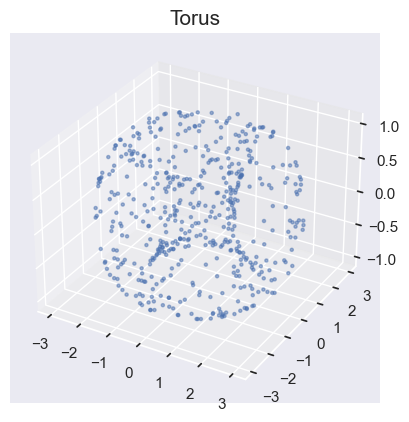

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=3, do_cocycles=False, n_perm = None, verbose=True)


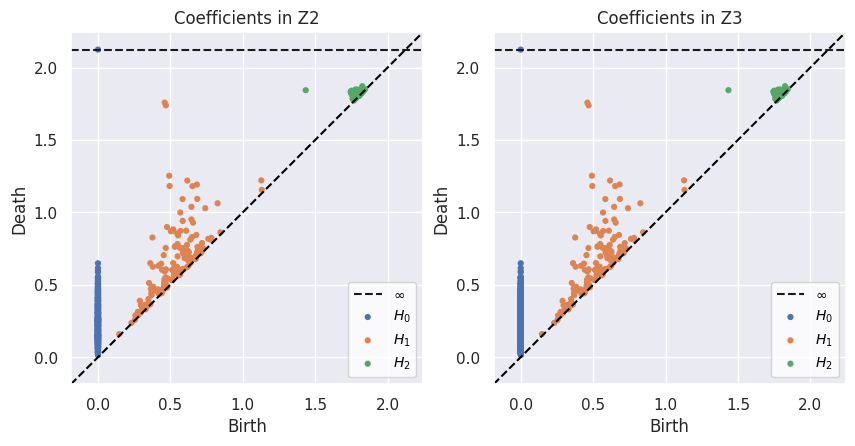

In [18]:
sns.set()
torus = tadasets.torus(n=500)
tadasets.plot3d(torus, s = 5, alpha = 0.5)
plt.title('Torus' , fontsize=15)
plt.show()

fig = plt.figure(figsize = (10,10))

sns.set()
plt.subplot(121)
rips = Rips(maxdim = 2, coeff = 2)
dgms = rips.fit_transform(torus)
rips.plot(dgms, title = 'Coefficients in Z2')

sns.set()
plt.subplot(122)
rips = Rips(maxdim = 2, coeff = 3)
dgms = rips.fit_transform(torus)
rips.plot(dgms, title = 'Coefficients in Z3')

In [19]:
import numpy as np 

def klein(theta, phi, r, a):
    x = (r*np.cos(theta) + a) * np.cos(phi)
    y = (r*np.cos(theta) + a) * np.sin(phi)
    z = r*np.sin(theta) * np.cos(phi/2)
    w = r*np.sin(theta) * np.sin(phi/2)
    return np.column_stack((np.concatenate(x),np.concatenate(y),np.concatenate(z),np.concatenate(w)))

n, m = 20,25
theta, phi = np.meshgrid(np.linspace(0, 2.*np.pi, n), np.linspace(0, 2.*np.pi, m))
klein = klein(theta, phi, 2, 1)

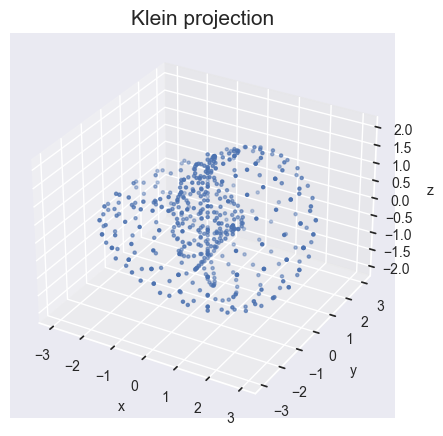

In [20]:
sns.set()
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection='3d')

ax.scatter(klein[:,0],klein[:,1],klein[:,2], s=5)
ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('y', fontsize=10)
ax.set_zlabel('z', fontsize=10)
plt.tick_params(labelsize=10)
ax.set_title('Klein projection', fontsize=15);

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=3, do_cocycles=False, n_perm = None, verbose=True)


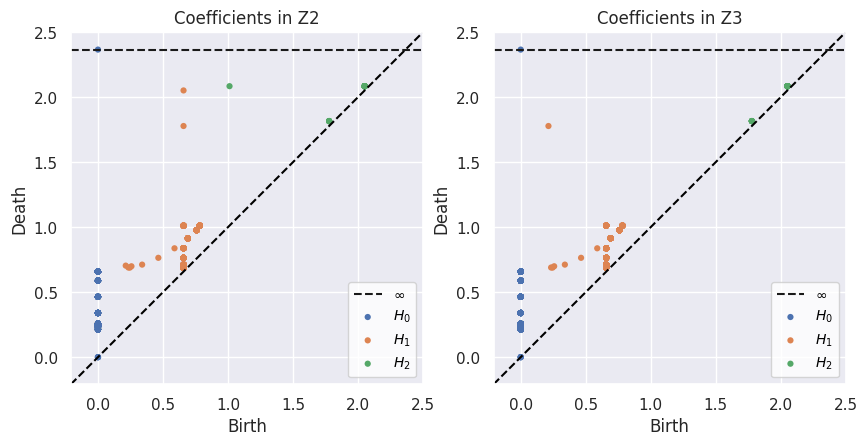

In [21]:
fig = plt.figure(figsize = (10,10))

sns.set()
plt.subplot(121)
rips = Rips(maxdim = 2, coeff = 2)
dgms = rips.fit_transform(klein)
rips.plot(dgms, title = 'Coefficients in Z2')

sns.set()
plt.subplot(122)
rips = Rips(maxdim = 2, coeff = 3)
dgms = rips.fit_transform(klein)
rips.plot(dgms, title = 'Coefficients in Z3')

*******************************************************************************************************************************
## 5. Singularities and boundary

- Stolz, B. J., Tanner, J., Harrington, H. A., & Nanda, V.  _Geometric anomaly detection in data._ **PNAS**, 117(33), 19664–19669 (2020).

<img src='figures/pnas_anomalies.jpg' width="650"> 

### Local homology

Methods based on _local homology_ can successfully detect **singular** or **boundary** regions, in which the local neighborhood is not homeomorphic to a disk. 

The _key construction_ is the set of **local homology groups** $$H_*(X, X \smallsetminus \{x\})$$ for all $x$ in the topological space $X$,  which in fact only depends on the local topology of $X$ around $x$ and are isomorphic to $$H_*(B(x,r)\cap X, B(x,r)\cap X  \smallsetminus \{x\})$$ for an open neighborhood $U$ of $x$.

In [22]:
def plane(l,n):
    return np.column_stack((np.random.sample(n)*2*l-l,np.random.sample(n)*2*l-l , np.zeros(n)))

In [23]:
plane_pc = plane(2, 2000)
sphere_pc = tadasets.dsphere(n=2000)
point_cloud = np.concatenate((plane_pc, sphere_pc), axis = 0)

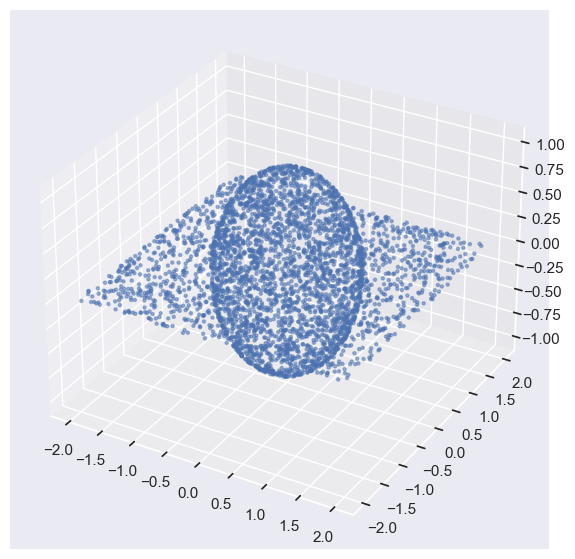

In [24]:
sns.set()
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], s=5, alpha = 0.5);

In [25]:
from scipy.spatial import distance_matrix

def local_neighborhood(data, scale):
    D = distance_matrix(data, data)
    n = scale[1]-scale[0]
    local_neigh = np.ndarray(shape=(len(D),n), dtype=int, order='F')
    radius = np.ndarray(shape=(len(D),2), dtype=float, order='F')
    for i in range(len(D)):
        local_neigh[i] = np.argsort(D[i])[scale[0]:scale[1]]
    D.sort()
    for i in range(len(D)):
        radius[i] = [D[i][scale[0]], D[i][scale[1]]]
    return local_neigh, radius

    
def compute_local_persistence(data, scale):
    k1 = scale[0]
    k2 = scale[1]
    
    local_neigh, radius = local_neighborhood(data, [k1, k2])
    
    rips = Rips()
    mask = []
    for i in range(len(data)):
        dgm = rips.fit_transform(data[local_neigh[i]])
        
        # here we only focus on betti 1

        lifetime = dgm[1][:,1]-dgm[1][:,0]

        r1 = radius[i][0]
        r2 = radius[i][1]
            
        N = np.where(lifetime>r2-r1)[0]

        if len(N)==0:
            mask.append(0) #boundary
        elif len(N)==1:
            mask.append(1) #regular point
        else:
            mask.append(2) # singular point

    return np.array(mask)

In [26]:
k2 = 80
k1 = 40
mask = compute_local_persistence(point_cloud, [k1, k2])

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


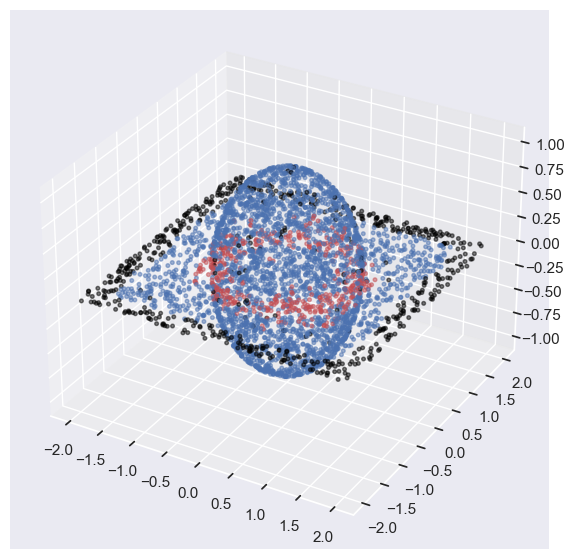

In [27]:
sns.set()
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(projection='3d')
colormap = np.array(['black', 'b', 'r'])
ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], s=7, c = colormap[mask], alpha = 0.5);

*******************************************************************************************************************************
## 6. Local dimension

**Property:** If a manifold has dimension $d$, then $H_k = 0$ for $k>d$.

In [28]:
def line(l,n):
    return np.column_stack((np.random.normal(0,0.01, n) , np.random.normal(0,0.01, n), np.random.sample(n)*2*l-l))

In [29]:
line_pc = line(10, 150)
sphere_pc = tadasets.dsphere(n=2000)
point_cloud = np.concatenate((line_pc, sphere_pc), axis = 0)

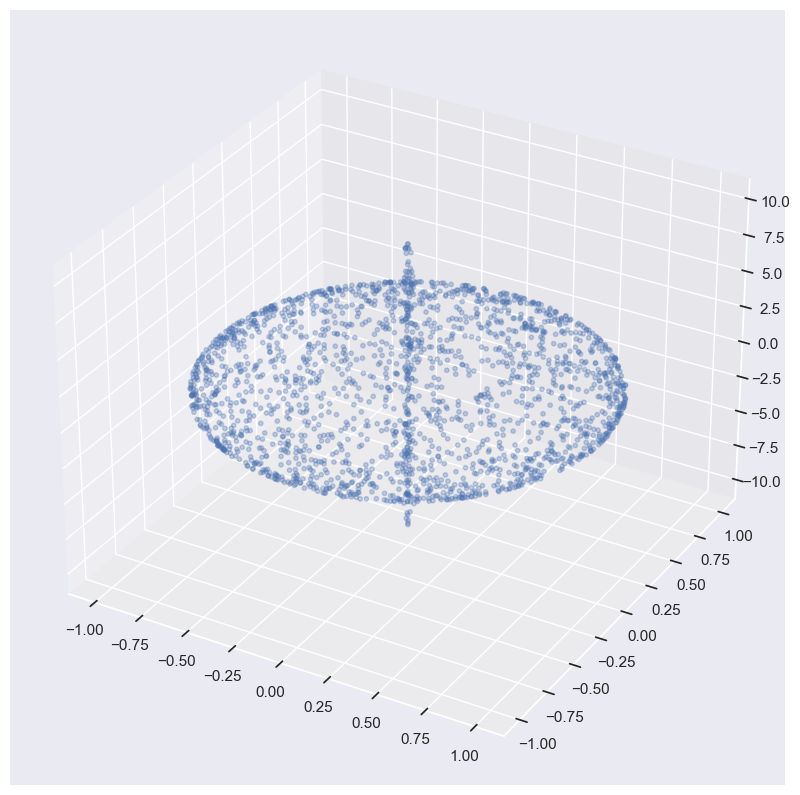

In [30]:
sns.set()
fig = plt.figure(figsize = (10,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], s=10, alpha = 0.3);

In [31]:
from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA

[0.51348574 0.48188376 0.0046305 ]


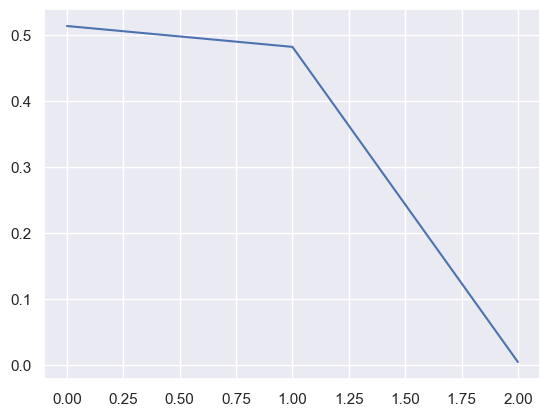

In [33]:
idx = 1000

# Local pointcloud
k= 50
kd_tree = KDTree(point_cloud, leaf_size=2)
dist, ind = kd_tree.query(np.array([point_cloud[idx]]), k = k)
local_pointcloud = point_cloud[ind[0]]

# apply PCA to the local pointcloud
n_components = 3
pca = PCA(n_components=n_components)
local_dimred = pca.fit_transform(local_pointcloud)
var = pca.explained_variance_ratio_
plt.plot(var);
print(var)

In [34]:
# construct local pointclouds
def local_pointclouds(k, pointcloud):
    kd_tree = KDTree(pointcloud, leaf_size=2)

    def neighbors_k(idx, k):
        return kd_tree.query(np.array([pointcloud[idx]]), k = k)

    def local_pointcloud(idx, k):
        dist, ind = neighbors_k(idx, k)
        return pointcloud[ind[0]]

    return np.array([local_pointcloud(i,k) for i in range(len(pointcloud))])


# apply PCA to local pointclouds
def local_pca(k, pointcloud, threshold, max_components = 10) :
    
    dimensions = []
    lp = local_pointclouds(k, pointcloud)
    max_components = min(max_components, len(pointcloud[0]))
    
    for i in range(len(pointcloud)) :
        local = lp[i]
        pca = PCA(n_components=max_components)
        local_dimred = pca.fit_transform(local)
        vs = pca.explained_variance_ratio_
        local_dim = 1
        recovered_variance = vs[local_dim-1]
        while recovered_variance < threshold:
            local_dim +=1
            recovered_variance = (vs[:local_dim]).sum()
        dimensions.append(local_dim)    
            
    return dimensions

In [35]:
dimensions = local_pca(50, point_cloud, 0.8)

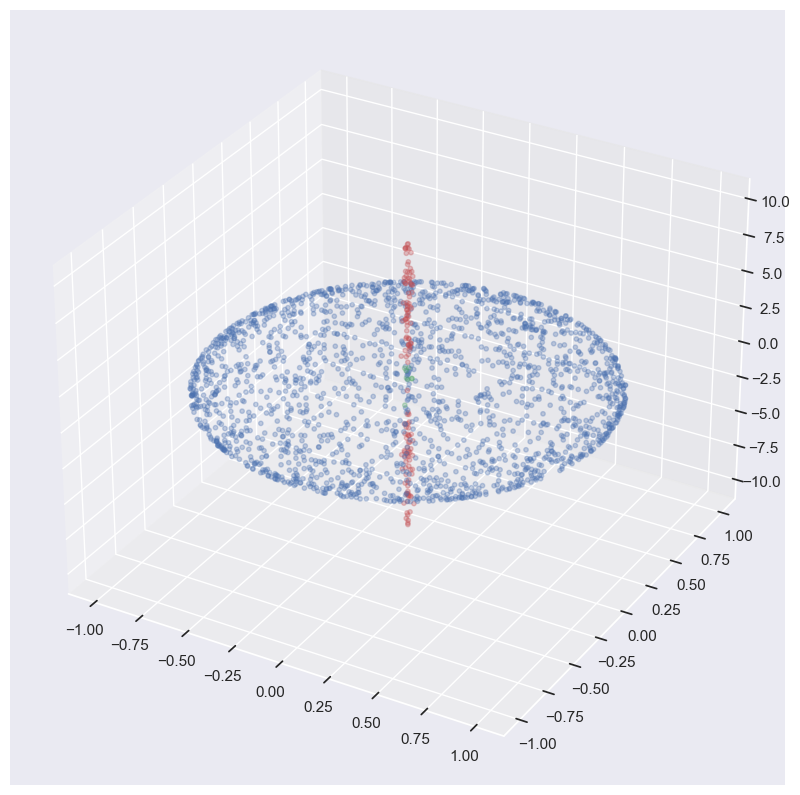

In [36]:
sns.set()
fig = plt.figure(figsize = (10,15))
ax = fig.add_subplot(projection='3d')
colormap = np.array(['black', 'r', 'b', 'g'])
ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], s=10, alpha = 0.3, c = colormap[dimensions]);

*******************************************************************************************************************************
## 7. An estimator of the intrinsic metric

Given a point cloud, compute kNN-distances for a given integer parameter $k>0$ as follows:

$$ d_{kNN}(x,y) = \displaystyle \inf_{\gamma}\sum_{i}|x_i-x_{i-1}|$$
    
where the infimum is over all finite paths $\gamma = (x_0 = x, x_1, \dots, x_{r-1}, x_r = y)$ between $x$ and $y$ over the kNN graph over the point cloud.
    
In the foundational [article](https://www.science.org/doi/10.1126/science.290.5500.2319) of the popular method ISOMAP, the authors show that if the sample belongs to a Riemannian manifold $\mathcal M$ embedded in the Euclidean space, then $d_{kNN}(x,y)$ converges to the geodesic distance $d_{\mathcal M}(x,y)$.

In [4]:
from fermat import Fermat
from scipy.spatial import distance_matrix

def compute_knn_distance(data, k):
    '''
    Computes the  estimator of geodesic distance of the algorithm ISOMAP.
    '''
    distances = distance_matrix(data,data)
    f_aprox_D = Fermat(1, path_method='D', k=k) 
    f_aprox_D.fit(distances)
    adj_dist = f_aprox_D.get_distances() 
    
    return adj_dist

In [7]:
def trefoil(n):
    '''
    Sample on trefoil curve.
    
    Input:
    n: an integer, number of points in the sample
    Output:
    data: a nx3 array, representing points in R^3
    '''
    
    phi = np.linspace(0,2*np.pi,n)
    
    X = np.sin(phi)+2*np.sin(2*phi)
    Y = np.cos(phi)-2*np.cos(2*phi)
    Z = - np.sin(3*phi)

    data = np.column_stack((X,Y,Z))
    
    return data

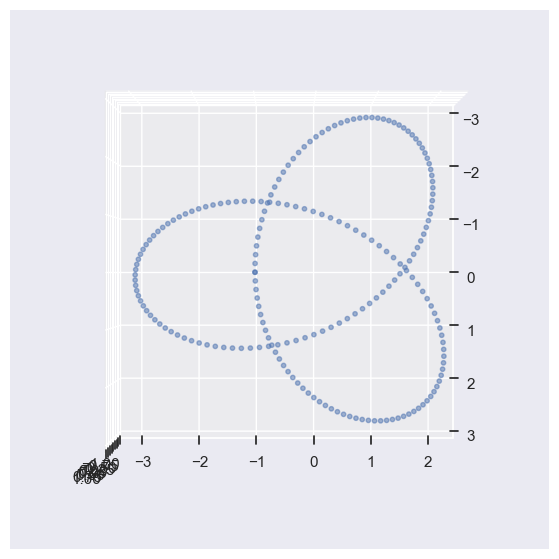

In [48]:
point_cloud = trefoil(200)
sns.set()
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], s=10, alpha = 0.5);
ax.view_init(90, 0)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


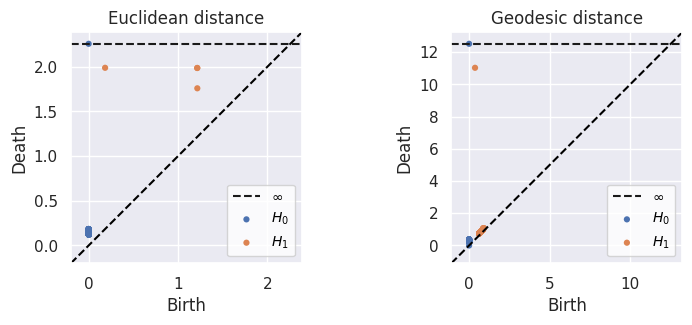

In [49]:
rips = Rips()
dgms = rips.fit_transform(point_cloud)
d_matrix = compute_knn_distance(point_cloud, 10)
dgms_intrinsic = rips.fit_transform(d_matrix, distance_matrix = True)

#Plot the curve and the persistent diagrams and compare
plt.figure(figsize=(9, 3))
ax = plt.subplot(121, projection='3d')

sns.set()
plt.subplot(121)
rips.plot(dgms)
plt.title("Euclidean distance");
sns.set()
plt.subplot(122)
rips.plot(dgms_intrinsic)
plt.title("Geodesic distance");

*******************************************************************************************************************************
## 8. Low dimensional visualization (ISOMAP)


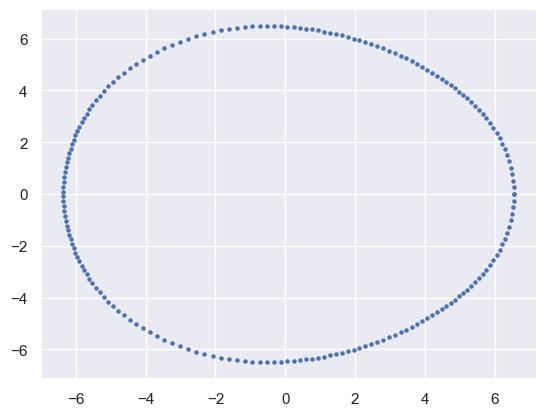

In [50]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components= 2, n_neighbors=10)

embedding_data = embedding.fit_transform(point_cloud)

sns.set()
fig = plt.figure()
plt.scatter(embedding_data[:,0], embedding_data[:,1], s=5);